# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/Glamdring/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model);

In [52]:
spl = MCHMC(0.0, 0.0; init_eps=0.07, varE_wanted=0.01, sigma=ones(2))
samples_mchmc = Sample(spl, target, 100_000;
                       burn_in=10_000,  
                       file_name="Turing_sequential_samples",
                       dialog=true);

Initial Virial loss: 19529.94534297032
Virial loss: 73.82486373095864 --> Relative improvement: 0.4717346321114656
Virial loss: 16.955102851415386 --> Relative improvement: 0.7703334351797086
Virial loss: 30.73616287351212 --> Relative improvement: 0.8127971940285996
Virial loss: 16.623396670249836 --> Relative improvement: 0.4591583621332387
Virial loss: 14.542297155108828 --> Relative improvement: 0.12519099173428616
Virial loss: 31.88174900554192 --> Relative improvement: 1.1923461379924833
Virial loss: 17.80534722929405 --> Relative improvement: 0.4415191203531841
Virial loss: 25.025419810178583 --> Relative improvement: 0.40550024034385523
Virial loss: 22.949798535625508 --> Relative improvement: 0.08294051769348776
Virial loss: 23.78455265499914 --> Relative improvement: 0.0363730478103248
Virial loss: 21.882446924008327 --> Relative improvement: 0.07997231474484001
Virial loss: 26.15079066015825 --> Relative improvement: 0.19505788136823532
Virial loss: 20.455539078546387 --> Re

[ Info: Using given sigma ✅
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Starting burn in ⏳
[ Info: Virial loss condition met during burn-in at step: 40
[ Info: Found eps: 0.026277790894932613 ✅


samples: 100--> 1/<1/ess>: 0.05503742677459455
samples: 203--> 1/<1/ess>: 0.017102863869498035
samples: 310--> 1/<1/ess>: 0.045869432947516955


[ Info: Found L: 0.22915296053473544 ✅


In [9]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

In [10]:
samples = samples_mchmc
#_samples = zeros(length(samples), length(samples[1]), 1)
#_samples[:, :, 1] = mapreduce(permutedims, vcat, samples)
#_samples = permutedims(_samples, (1,3,2))
#ess, rhat = MCMCDiagnosticTools.ess_rhat(_samples)

100001-element Vector{Any}:
 [0.3311446834701242, 1.0718801798746618, 0.0, -14.016438648355017]
 [0.20675659715520645, 0.8710972495698026, -0.07720001271512444, 16.24833822103501]
 [0.207121763944426, 0.8604331109163724, -0.2929228295014603, 16.149745686076386]
 [0.20786025198388747, 0.8509527733279237, -0.41003983306499237, 16.009117691278327]
 [0.20870888271114543, 0.8420132373330239, -0.5141863791095815, 15.830634506839196]
 [0.20994543100175272, 0.8362084373555992, -0.3384382875044487, 15.708151545265057]
 [0.21139228150402284, 0.8347649641750455, -0.005371508380227041, 15.705773507426542]
 [0.2126940243097383, 0.8398111121984917, 0.46432440488468707, 15.871076481282776]
 [0.21382131488916847, 0.8468738539986422, 0.505577624093382, 16.046442928723305]
 [0.21475374284347387, 0.8554018031350014, 0.43340864602734186, 16.19396555101755]
 [0.21544823836388347, 0.8651244191805938, 0.275880820776468, 16.286686212375898]
 [0.21587848709490368, 0.8756675121464625, 0.05175057684768447, 16.30

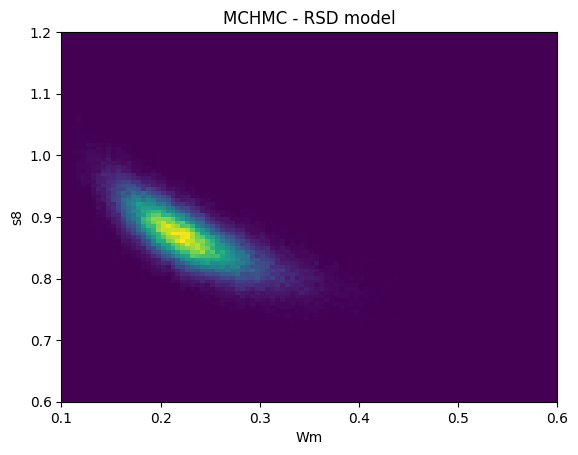

In [11]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

In [53]:
spl = MCHMC(0.0, 0.0, 10; init_eps=0.07, varE_wanted=0.1)
samples_ensemble_mchmc = Sample(spl, target, 10000;
                                burn_in=1000,
                                monitor_energy=true, 
                                dialog=true);

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳


Initial sigma: [0.5538440804853947, 0.3904013432418407]
Initial Virial loss: 10860.663721234809
Virial loss: 85.52383451050731 --> Relative improvement: 0.17934809672539842
Sigma --> [0.5391392987847256, 0.36892219430780204]
Virial loss: 68.24675969539909 --> Relative improvement: 0.2020147355879558
Sigma --> [0.533593032066484, 0.35541055028066004]
Virial loss: 49.955623552071245 --> Relative improvement: 0.26801471930631393
Sigma --> [0.5300472912259464, 0.3440264184490787]
Virial loss: 34.25796797808957 --> Relative improvement: 0.31423200148065866
Sigma --> [0.5271306904574533, 0.3337528529501476]
Virial loss: 20.71024392595249 --> Relative improvement: 0.3954619859765711
Sigma --> [0.5240310879111264, 0.3241809865846637]
Virial loss: 11.566749349475202 --> Relative improvement: 0.4414962281066792
Sigma --> [0.5208846081590288, 0.3151907021809891]
Virial loss: 5.613459153498994 --> Relative improvement: 0.514689997691211
Sigma --> [0.5179370431372001, 0.3067334819585175]
Virial los

[ Info: Starting burn in ⏳


Virial loss: 42.00003200317537 --> Relative improvement: 0.0206103116497538
Sigma --> [0.4932770133146841, 0.2445142531659258]
Virial loss: 39.273107565305054 --> Relative improvement: 0.06492672285735757
Sigma --> [0.4897393739363716, 0.23912884623672293]
Virial loss: 37.31640241854584 --> Relative improvement: 0.049823028226261834
Sigma --> [0.4860695802251163, 0.2340414953549749]
Virial loss: 35.38203894473627 --> Relative improvement: 0.05183681567460563
Sigma --> [0.48235431853094257, 0.22923088452031223]
Virial loss: 32.390740132693466 --> Relative improvement: 0.08454286132901956
Sigma --> [0.4786149371673035, 0.2247001970095478]
Virial loss: 30.116236099532294 --> Relative improvement: 0.07022081075774522
Sigma --> [0.4748239675068701, 0.22042193074959962]
Virial loss: 29.331787852986707 --> Relative improvement: 0.02604735345921161
Sigma --> [0.4710208393598121, 0.21634374497346162]
Virial loss: 28.180433508870298 --> Relative improvement: 0.039252784381473504
Sigma --> [0.467

[ Info: Virial loss condition met during burn-in at step: 36
[ Info: Found sigma: [0.4481931960616722, 0.17551431269563336] ✅
[ Info: Found eps: 0.12413177378606531 ✅


samples: 100--> 1/<1/ess>: 0.0033667998392621135
samples: 203--> 1/<1/ess>: 0.003248489426679038
samples: 310--> 1/<1/ess>: 0.0031232113446503736
samples: 420--> 1/<1/ess>: 0.003042822378831595
samples: 534--> 1/<1/ess>: 0.002929316667398892
samples: 652--> 1/<1/ess>: 0.0028341220385161257
samples: 774--> 1/<1/ess>: 0.00274270813958923
samples: 900--> 1/<1/ess>: 0.002658812294156815
samples: 1030--> 1/<1/ess>: 0.00256447327448685
samples: 1164--> 1/<1/ess>: 0.0025032181922884397
samples: 1302--> 1/<1/ess>: 0.002427694334539047
samples: 1445--> 1/<1/ess>: 0.002341027190299999
samples: 1593--> 1/<1/ess>: 0.002267265712193825
samples: 1746--> 1/<1/ess>: 0.0021946287866099097
samples: 1904--> 1/<1/ess>: 0.0021171406850933154
samples: 2067--> 1/<1/ess>: 0.002053192526148481
samples: 2235--> 1/<1/ess>: 0.0019989839051869265
samples: 2409--> 1/<1/ess>: 0.0019241215691294749
samples: 2589--> 1/<1/ess>: 0.0018675009722574321
samples: 2774--> 1/<1/ess>: 0.0018193070491853748
samples: 2966--> 1/<

[ Info: Found L: 53.21163586271022 ✅


In [54]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

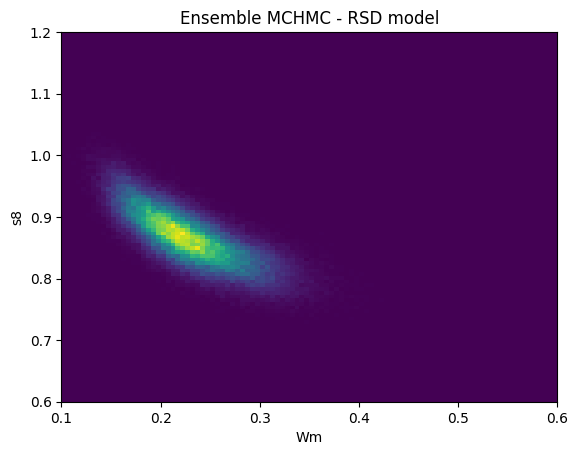

In [55]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

##  AbstractMCMC

In [15]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    dialog=true)

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳


LoadError: DomainError with -0.33934227649544785:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

In [16]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run


LoadError: type Array has no field info

## Ensemble AbstractMCMC

In [16]:
samples = sample(stat_model, MCHMC(100), 1000, 100)

[ Info: Burn-in started ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
┌ Warning: L-tuning not Implemented
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:41
[ Info: Found L: 1.4142135623730951 ✅
[ Info: VarE condition met during eps tuning at step: 13
[ Info: Found eps: 0.008664620420202015 ✅
[ Info: Virial loss condition met during burn-in at step: 2
[ Info: Found sigma: [1.620616898256196, 0.2532292543539198] ✅
┌ Warning: Maximum number of steps reached during eps tuning
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:214
[ Info: Found eps: 0.0043824511407622386 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:04


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 6.0 seconds
Compute duration  = 6.0 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2901    0.1673     0.0005    0.0088   233.6325    1.0001     ⋯
          σ8    0.7617    0.2533     0.0008    0.0133   232.2530    1.0074     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.0259    0.1396    0.2759    0.4387    0.5603
          σ8    0.3356    0.5914    0.7780    0.9295    1.2868


In [17]:
new_samples = sample(stat_model, MCHMC(100), 1000, 100; 
                     resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 3.38 seconds
Compute duration  = 3.38 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2404    0.0736     0.0002    0.0040   224.4534    1.0585     ⋯
          σ8    0.8627    0.0653     0.0002    0.0035   226.0813    1.0283     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1345    0.1857    0.2350    0.2774    0.4314
          σ8    0.7524    0.8142    0.8569    0.9029    0.9855


## Parallelization

In [18]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

[ Info: number of chains: 4 smaller than number of threads: 10. Increase the number of chains to make full use of your threads.
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳


LoadError: TaskFailedException

[91m    nested task error: [39mDomainError with -0.33934227649544785:
    sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).
    Stacktrace:
      [1] [0m[1mthrow_complex_domainerror[22m[0m[1m([22m[90mf[39m::[0mSymbol, [90mx[39m::[0mFloat64[0m[1m)[22m
    [90m    @[39m [90mBase.Math[39m [90m./[39m[90m[4mmath.jl:33[24m[39m
      [2] [0m[1msqrt[22m
    [90m    @[39m [90m./[39m[90m[4mmath.jl:677[24m[39m[90m [inlined][39m
      [3] [0m[1m_broadcast_getindex_evalf[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:683[24m[39m[90m [inlined][39m
      [4] [0m[1m_broadcast_getindex[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:656[24m[39m[90m [inlined][39m
      [5] [0m[1mgetindex[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:610[24m[39m[90m [inlined][39m
      [6] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:974[24m[39m[90m [inlined][39m
      [7] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4msimdloop.jl:77[24m[39m[90m [inlined][39m
      [8] [0m[1mcopyto![22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:973[24m[39m[90m [inlined][39m
      [9] [0m[1mcopyto![22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:926[24m[39m[90m [inlined][39m
     [10] [0m[1mcopy[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:898[24m[39m[90m [inlined][39m
     [11] [0m[1mmaterialize[22m[0m[1m([22m[90mbc[39m::[0mBase.Broadcast.Broadcasted[90m{Base.Broadcast.DefaultArrayStyle{1}, Nothing, typeof(sqrt), Tuple{Vector{Float64}}}[39m[0m[1m)[22m
    [90m    @[39m [90mBase.Broadcast[39m [90m./[39m[90m[4mbroadcast.jl:873[24m[39m
     [12] [0m[1mtune_sigma![22m[0m[1m([22m[90msampler[39m::[0mMicroCanonicalHMC.Sampler, [90mtarget[39m::[0mTuringTarget; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}[39m[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:89[24m[39m
     [13] [0m[1mtune_sigma![22m
    [90m    @[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:83[24m[39m[90m [inlined][39m
     [14] [0m[1mtune_hyperparameters[22m[0m[1m([22m[90msampler[39m::[0mMicroCanonicalHMC.Sampler, [90mtarget[39m::[0mTuringTarget, [90minit[39m::[0mTuple[90m{Vector{Float64}, Vector{Float64}, Float64, Vector{Float64}, Float64}[39m; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}[39m[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:155[24m[39m
     [15] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mabstractmcmc.jl:220[24m[39m[90m [inlined][39m
     [16] [0m[1m(::MicroCanonicalHMC.var"#902#threadsfor_fun#95"{MicroCanonicalHMC.var"#902#threadsfor_fun#84#96"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m./[39m[90m[4mthreadingconstructs.jl:139[24m[39m
     [17] [0m[1m#902#threadsfor_fun[22m
    [90m    @[39m [90m./[39m[90m[4mthreadingconstructs.jl:106[24m[39m[90m [inlined][39m
     [18] [0m[1m(::Base.Threads.var"#1#2"{MicroCanonicalHMC.var"#902#threadsfor_fun#95"{MicroCanonicalHMC.var"#902#threadsfor_fun#84#96"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m

...and 3 more exceptions.


In [19]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

[ Info: Starting from previous run


LoadError: MethodError: no method matching iterate(::Chains{Float64, AxisArrays.AxisArray{Float64, 3, Array{Float64, 3}, Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}}, Missing, NamedTuple{(:parameters, :internals), Tuple{Vector{Symbol}, Vector{Symbol}}}, NamedTuple{(:target, :sampler, :init, :start_time, :stop_time), Tuple{ParallelTarget, MicroCanonicalHMC.EnsembleSampler, Tuple{Tuple{Matrix{Float64}, Matrix{Float64}, Vector{Real}, Matrix{Real}, Vector{Float64}}, Tuple{Matrix{Real}, Vector{Float64}, Vector{Float64}}}, Float64, Float64}}})

[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}}
[0m[90m   @[39m [90mBase[39m [90m[4mdict.jl:698[24m[39m
[0m  ...


## NUTS

In [28]:
typeof(zeros(2,2,2))

Array{Float64, 3}

In [20]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 11.66 seconds
Compute duration  = 11.66 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2403    0.0683     0.0007    0.0017   1405.0343    1.0006    ⋯
          σ8    0.8637    0.0619     0.0006    0.0012   2356.8676    1.0002    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.195289  0.931189  15.6471   7.0  1.0  …  2.0  0.0  0.0471045  0.0471045
 0.194965  0.891184  16.194    3.0  1.0     1.0  0.0  0.0471045  0.0471045
 0.20792   0.883536  16.2748  15.0  1.0     3.0  0.0  0.0471045  0.0471045
 0.252361  0.838644  16.1968  31.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.251986  0.825046  16.0557   1.0  1.0     1.0  0.0  0.0471045  0.0471045
 0.24801   0.831916  16.1395   3.0  1.0  …  2.0  0.0  0.0471045  0.0471045
 0.195668  0.864144  15.9732  21.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.264617  0.863147  15.8853  19.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.272399  0.787847  15.258    7.0  1.0 

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

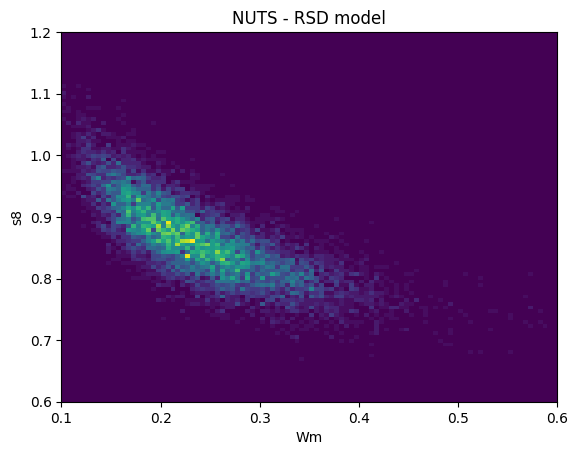

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");